In [1]:
import torch
import torchvision
from torch import nn 
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
#%matplotlib inline
import numpy as np

In [2]:
df = pd.read_csv('final_dataset.csv',index_col=0)

In [3]:
tform = transforms.Compose([transforms.Resize((64,64)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)


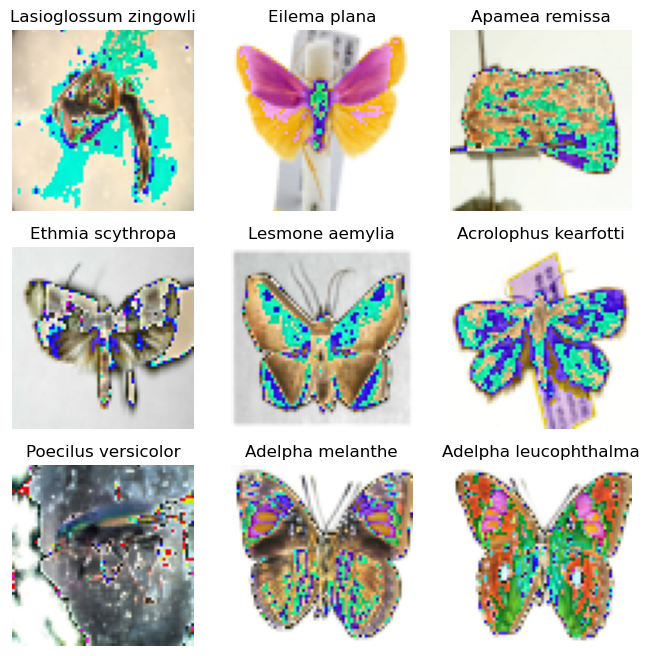

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(image_dataset), size=(1,)).item()
    img, label = image_dataset[sample_idx]
    img = transforms.functional.to_pil_image(img)
    figure.add_subplot(rows, cols, i)
    species_name = (list(image_dataset.class_to_idx.keys())[label]).replace('_',' ')
    plt.title(species_name)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [5]:
import dataset_utils
img2dna = dataset_utils.get_imgs_bold_id(image_dataset,df)

In [6]:
import random


nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(dataset_utils.one_hot_encoding)
random.seed(42)

X_train_1, X_test, y_train_1, y_test = dataset_utils.data_split(nucleotides,0.3)

train_data = X_train_1
train_data['species_name'] = y_train_1

X_train, X_validation, y_train, y_validation = dataset_utils.data_split(train_data,0.2,drop_labels=False)
train_indices, val_indices, test_indices = dataset_utils.image_splits_from_df(X_train,X_validation,X_test,image_dataset)

In [7]:
from torch.utils.data import Dataset, DataLoader

class WholeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.targets = data.targets#torch.tensor(targets)
        #self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.targets[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
whole_dataset = WholeDataset(image_dataset)
#whole_dataset[0][0].shape
print(len(test_indices+val_indices+train_indices))
len(whole_dataset)

32424


32424

In [9]:
train_imgs = torch.utils.data.Subset(whole_dataset, train_indices)
val_imgs = torch.utils.data.Subset(whole_dataset, val_indices)
test_imgs = torch.utils.data.Subset(whole_dataset, test_indices)
len(train_imgs)+len(val_imgs)+len(test_imgs)
batch_size = 2048
train_loader = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size,shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_imgs, batch_size=batch_size,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_imgs, batch_size=4,shuffle=True, num_workers=2)
del test_loader
dataloaders = {"train":train_loader,"val":val_loader}
dataset_sizes = {'train': len(train_imgs.indices), 'val':len(val_imgs.indices)}

print(len(train_imgs.indices))
print(len(val_imgs.indices))
print(len(test_imgs.indices))


10777
6734
14913


In [10]:
class Discriminator(torch.nn.Module):

    def __init__(self,n_feature_maps):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3,n_feature_maps,4,2,1,bias=False)
        self.relu1 = nn.LeakyReLU(0.2,inplace=True)
        self.conv2 = nn.Conv2d(n_feature_maps,2*n_feature_maps,4,2,1,bias=False)
        self.bn2 = nn.BatchNorm2d(n_feature_maps * 2)
        self.relu2 = nn.LeakyReLU(0.2, inplace=True)
        self.conv3 = nn.Conv2d(n_feature_maps * 2, n_feature_maps * 4, 4, 2,1, bias=False)
        self.bn3 = nn.BatchNorm2d(n_feature_maps * 4)
        self.relu3 = nn.LeakyReLU(0.2, inplace=True)
        self.conv4 = nn.Conv2d(n_feature_maps * 4, n_feature_maps * 8, 4, 2,1,bias=False)
        self.bn4 = nn.BatchNorm2d(n_feature_maps * 8)
        self.relu4 = nn.LeakyReLU(0.2, inplace=True)
        self.conv5 = nn.Conv2d(n_feature_maps * 8, 1, 4, 1,0,bias=False)
        self.sigmoid5 = nn.Sigmoid()
        
        self.main = nn.Sequential(self.conv1,
                                  self.relu1,
                                  self.conv2,
                                  self.bn2,
                                  self.relu2,
                                  self.conv3,        
                                  self.bn3,
                                  self.relu3,
                                  self.conv4,
                                  self.bn4,
                                  self.relu4,
                                  self.conv5,
                                  self.sigmoid5)
    def forward(self, x):
        return self.main(x)

class Generator(nn.Module):
    def __init__(self, n_feature_maps,noise_size):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( noise_size, n_feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(n_feature_maps * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(n_feature_maps * 8, n_feature_maps* 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_feature_maps * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( n_feature_maps * 4, n_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_feature_maps * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( n_feature_maps * 2, n_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_feature_maps),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( n_feature_maps, 3, 4, 2, 1, bias=False),
            #nn.BatchNorm2d(n_feature_maps),
            #nn.ReLU(True),
            #nn.ConvTranspose2d( n_feature_maps, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)
discriminator = Discriminator(64)
discriminator.cuda()

generator = Generator(64,noise_size=100)
generator.cuda()

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),lr=2e-4,betas=(0.5, 0.999))
#discriminator_scheduler = torch.optim.lr_scheduler.OneCycleLR(discriminator_optimizer,max_lr=0.005,epochs= 25, steps_per_epoch= 10) 

generator_optimizer = torch.optim.Adam(generator.parameters(),lr=2e-4,betas=(0.5, 0.999))
#generator_scheduler = torch.optim.lr_scheduler.OneCycleLR(generator_optimizer,max_lr=0.005,epochs= 25, steps_per_epoch= 10) 

In [11]:
n_params = dataset_utils.count_trainable_parameters(discriminator);
print(n_params)
n_params = dataset_utils.count_trainable_parameters(generator);
print(n_params)


2765568
3576704


In [12]:
import os
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

In [13]:
from tqdm.notebook import tqdm

fixed_latent = torch.randn(200, 100, 1, 1,device=device)
def train_discriminator(real_images, discriminator_optimizer,discriminator,batch_size,latent_size,device):
    # Clear discriminator gradients
    discriminator_optimizer.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1,1,1, device=device)
    #print(real_preds.shape)
    #print(real_targets.shape)
    #real_targets = real_targets.unsqueeze()
    real_loss = nn.functional.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1,1,1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = nn.functional.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    discriminator_optimizer.step()
    return loss.item(), real_score, fake_score
    
def train_generator(generator_optimizer,generator,batch_size,latent_size,device):
    # Clear generator gradients
    generator_optimizer.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1,device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1,1,1, device=device)
    loss = nn.functional.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    generator_optimizer.step()
    
    return loss.item()
def fit(epochs,discriminator_optimizer,generator_optimizer,discriminator,generator,start_idx=1,latent_size =100):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(dataloaders['train']):
            # Train discriminator
            real_images = real_images.to(device)
            loss_d, real_score, fake_score = train_discriminator(real_images, discriminator_optimizer,discriminator,batch_size,100,device)
            # Train generator
            loss_g = train_generator(generator_optimizer,generator,batch_size,latent_size,device)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [14]:
#train_model(tinymodel,torch.nn.CrossEntropyLoss(),optimizer,scheduler)

In [ ]:
losses_g, losses_d ,real_scores, fake_scores =fit(100,discriminator_optimizer,generator_optimizer,discriminator,generator,start_idx=1)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 5.5162, loss_d: 0.5566, real_score: 0.8135, fake_score: 0.2539
Saving generated-images-0001.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 7.9090, loss_d: 0.1789, real_score: 0.9495, fake_score: 0.1072
Saving generated-images-0002.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 7.1320, loss_d: 0.0930, real_score: 0.9676, fake_score: 0.0455
Saving generated-images-0003.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 7.4261, loss_d: 0.0250, real_score: 0.9795, fake_score: 0.0028
Saving generated-images-0004.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 6.8915, loss_d: 0.0220, real_score: 0.9877, fake_score: 0.0090
Saving generated-images-0005.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 13.8422, loss_d: 0.1313, real_score: 0.9935, fake_score: 0.1168
Saving generated-images-0006.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 18.7389, loss_d: 0.6039, real_score: 0.6844, fake_score: 0.0000
Saving generated-images-0007.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 14.6270, loss_d: 0.1664, real_score: 0.9976, fake_score: 0.1504
Saving generated-images-0008.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 13.0813, loss_d: 0.0075, real_score: 0.9932, fake_score: 0.0000
Saving generated-images-0009.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 16.5311, loss_d: 0.0215, real_score: 0.9827, fake_score: 0.0000
Saving generated-images-0010.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 13.9384, loss_d: 2.7566, real_score: 0.2457, fake_score: 0.0000
Saving generated-images-0011.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 4.4120, loss_d: 0.1615, real_score: 0.9683, fake_score: 0.1010
Saving generated-images-0012.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 8.6814, loss_d: 2.8338, real_score: 0.9664, fake_score: 0.8839
Saving generated-images-0013.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 3.0621, loss_d: 0.4317, real_score: 0.8551, fake_score: 0.2084
Saving generated-images-0014.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 3.7160, loss_d: 0.9467, real_score: 0.4822, fake_score: 0.0113
Saving generated-images-0015.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 2.0423, loss_d: 0.5270, real_score: 0.6764, fake_score: 0.0694
Saving generated-images-0016.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 3.6936, loss_d: 0.4813, real_score: 0.8093, fake_score: 0.2164
Saving generated-images-0017.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 1.7213, loss_d: 0.4091, real_score: 0.8318, fake_score: 0.1722
Saving generated-images-0018.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 2.3593, loss_d: 0.4521, real_score: 0.8014, fake_score: 0.1860
Saving generated-images-0019.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 1.2276, loss_d: 1.5500, real_score: 0.2981, fake_score: 0.0255
Saving generated-images-0020.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 3.4781, loss_d: 0.6905, real_score: 0.9149, fake_score: 0.4192
Saving generated-images-0021.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 3.3667, loss_d: 0.3907, real_score: 0.8557, fake_score: 0.1879
Saving generated-images-0022.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 1.4357, loss_d: 0.7083, real_score: 0.7624, fake_score: 0.2573
Saving generated-images-0023.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 3.2257, loss_d: 0.5142, real_score: 0.8084, fake_score: 0.2372
Saving generated-images-0024.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 2.3687, loss_d: 0.4241, real_score: 0.8499, fake_score: 0.1993
Saving generated-images-0025.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 2.8038, loss_d: 0.3832, real_score: 0.8485, fake_score: 0.1770
Saving generated-images-0026.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 3.7389, loss_d: 0.5790, real_score: 0.6365, fake_score: 0.0562
Saving generated-images-0027.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 1.4275, loss_d: 0.4988, real_score: 0.7041, fake_score: 0.0962
Saving generated-images-0028.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 3.7579, loss_d: 0.5273, real_score: 0.9268, fake_score: 0.3435
Saving generated-images-0029.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 4.2690, loss_d: 0.6011, real_score: 0.8645, fake_score: 0.3452
Saving generated-images-0030.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 2.4962, loss_d: 0.5963, real_score: 0.6498, fake_score: 0.0945
Saving generated-images-0031.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 1.1815, loss_d: 0.9805, real_score: 0.4662, fake_score: 0.0681
Saving generated-images-0032.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 2.8421, loss_d: 0.6054, real_score: 0.8368, fake_score: 0.3196
Saving generated-images-0033.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 1.3802, loss_d: 0.4960, real_score: 0.6867, fake_score: 0.0610
Saving generated-images-0034.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 1.6193, loss_d: 0.5918, real_score: 0.8076, fake_score: 0.2734
Saving generated-images-0035.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 2.7762, loss_d: 0.7220, real_score: 0.8097, fake_score: 0.3742
Saving generated-images-0036.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 3.1088, loss_d: 0.5480, real_score: 0.8642, fake_score: 0.3081
Saving generated-images-0037.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 2.7420, loss_d: 0.6096, real_score: 0.9128, fake_score: 0.3718
Saving generated-images-0038.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 1.1908, loss_d: 1.5333, real_score: 0.3182, fake_score: 0.0458
Saving generated-images-0039.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 2.2886, loss_d: 0.7769, real_score: 0.7739, fake_score: 0.3704
Saving generated-images-0040.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 4.0262, loss_d: 0.8294, real_score: 0.8781, fake_score: 0.4780
Saving generated-images-0041.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 1.9061, loss_d: 0.5870, real_score: 0.7272, fake_score: 0.2041
Saving generated-images-0042.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 1.2719, loss_d: 2.3998, real_score: 0.1254, fake_score: 0.0185
Saving generated-images-0043.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 4.3958, loss_d: 1.2232, real_score: 0.9196, fake_score: 0.6505
Saving generated-images-0044.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 1.0973, loss_d: 0.9523, real_score: 0.4780, fake_score: 0.1167
Saving generated-images-0045.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 1.8274, loss_d: 0.6121, real_score: 0.6708, fake_score: 0.1514
Saving generated-images-0046.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 1.0576, loss_d: 1.6205, real_score: 0.2756, fake_score: 0.0791
Saving generated-images-0047.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 1.4634, loss_d: 0.7657, real_score: 0.5668, fake_score: 0.1095
Saving generated-images-0048.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 2.0075, loss_d: 0.6620, real_score: 0.6185, fake_score: 0.1198
Saving generated-images-0049.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 1.7147, loss_d: 0.6027, real_score: 0.6741, fake_score: 0.1572
Saving generated-images-0050.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 2.0862, loss_d: 0.7321, real_score: 0.5859, fake_score: 0.1124
Saving generated-images-0051.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 2.5875, loss_d: 0.5917, real_score: 0.8153, fake_score: 0.3005
Saving generated-images-0052.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 4.2185, loss_d: 1.4086, real_score: 0.9250, fake_score: 0.6797
Saving generated-images-0053.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 2.9367, loss_d: 0.8520, real_score: 0.7944, fake_score: 0.4308
Saving generated-images-0054.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 2.8597, loss_d: 0.6665, real_score: 0.8057, fake_score: 0.3397
Saving generated-images-0055.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 3.7255, loss_d: 0.7730, real_score: 0.9270, fake_score: 0.4703
Saving generated-images-0056.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 4.4779, loss_d: 0.6511, real_score: 0.8585, fake_score: 0.3707
Saving generated-images-0057.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 1.9029, loss_d: 0.9085, real_score: 0.4965, fake_score: 0.1017
Saving generated-images-0058.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 2.5591, loss_d: 0.8057, real_score: 0.7545, fake_score: 0.3717
Saving generated-images-0059.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 2.5124, loss_d: 0.7019, real_score: 0.8103, fake_score: 0.3631
Saving generated-images-0060.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 0.6749, loss_d: 0.9877, real_score: 0.4610, fake_score: 0.1084
Saving generated-images-0061.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 2.5829, loss_d: 0.6459, real_score: 0.7973, fake_score: 0.3174
Saving generated-images-0062.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 2.3704, loss_d: 0.8174, real_score: 0.8715, fake_score: 0.4573
Saving generated-images-0063.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 1.4361, loss_d: 0.9075, real_score: 0.4875, fake_score: 0.0876
Saving generated-images-0064.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 1.4477, loss_d: 0.8574, real_score: 0.5171, fake_score: 0.0945
Saving generated-images-0065.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 2.0700, loss_d: 0.5500, real_score: 0.7431, fake_score: 0.1989
Saving generated-images-0066.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 1.5164, loss_d: 1.3739, real_score: 0.3345, fake_score: 0.0321
Saving generated-images-0067.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.5088, loss_d: 1.1456, real_score: 0.8673, fake_score: 0.5982
Saving generated-images-0068.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 2.0436, loss_d: 0.8227, real_score: 0.6461, fake_score: 0.2779
Saving generated-images-0069.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 1.6581, loss_d: 1.4337, real_score: 0.3104, fake_score: 0.0700
Saving generated-images-0070.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 3.1755, loss_d: 0.9610, real_score: 0.8628, fake_score: 0.5271
Saving generated-images-0071.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 2.8136, loss_d: 0.7000, real_score: 0.7603, fake_score: 0.3163
Saving generated-images-0072.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 2.3993, loss_d: 0.6109, real_score: 0.8659, fake_score: 0.3426
Saving generated-images-0073.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 0.7189, loss_d: 1.1846, real_score: 0.3613, fake_score: 0.0484
Saving generated-images-0074.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 2.6685, loss_d: 0.7055, real_score: 0.7611, fake_score: 0.3218
Saving generated-images-0075.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 2.2871, loss_d: 0.6676, real_score: 0.8996, fake_score: 0.4067
Saving generated-images-0076.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 1.1941, loss_d: 0.8774, real_score: 0.5077, fake_score: 0.1064
Saving generated-images-0077.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 2.4779, loss_d: 0.6090, real_score: 0.7723, fake_score: 0.2680
Saving generated-images-0078.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 6.9358, loss_d: 1.3766, real_score: 0.9485, fake_score: 0.7089
Saving generated-images-0079.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 1.1516, loss_d: 0.7699, real_score: 0.5627, fake_score: 0.1221
Saving generated-images-0080.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 2.9065, loss_d: 0.7351, real_score: 0.7968, fake_score: 0.3738
Saving generated-images-0081.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 2.6737, loss_d: 0.8857, real_score: 0.8543, fake_score: 0.4901
Saving generated-images-0082.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 2.1605, loss_d: 0.6146, real_score: 0.7356, fake_score: 0.2420
Saving generated-images-0083.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 1.7591, loss_d: 1.1424, real_score: 0.3726, fake_score: 0.0406
Saving generated-images-0084.png


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 3.2024, loss_d: 0.6833, real_score: 0.8358, fake_score: 0.3742
Saving generated-images-0085.png


  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
torch.save({
            'epoch':100,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': generator_optimizer.state_dict(),
            }, "checkpoints/2048generator_checkpoint100")
torch.save({
            'epoch': 100,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': discriminator_optimizer.state_dict(),
            }, "checkpoints/2048discriminator_checkpoint100")